In [65]:
import numpy as np
from DoALib import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [66]:
#Number of antenna array elements
n_antennas = 8

#Number of multipaths
n_multipaths = 2
#Frequency of the signal 10 MHz
f_c = 10e6
#Wavelength
lamb = 3e8/f_c
#Space between the elements
delta = lamb/2 #in meters
#Light speed
c = 3e8


In [67]:
#Antenna array
antenna_array = np.arange(0, n_antennas, 1)
A_ula = np.zeros((n_antennas, n_multipaths), dtype=complex)
#Diagonal weighting matrix
W = np.array([[5, 0],[0, 5]])

In [68]:
#SNR values
snr_vector = np.arange(-5, 21, 5)
#Number of snapshots
snapshots = 50
#Number of Monte Carlo simulations
n_monte_carlo = 50
sqr_half = np.sqrt(0.5)
first_angle_error_vector = []
second_angle_error_vector = []
s_t = np.random.normal(0,sqr_half,(n_multipaths,snapshots)) + 1j * np.random.normal(0,sqr_half,(n_multipaths,snapshots))
range_angles = np.linspace(-60/180 * np.pi, 60/180 * np.pi, 1000)

for snr_index in tqdm(range(len(snr_vector))):
    snr = snr_vector[snr_index]
    error_vector = np.zeros((n_multipaths,n_monte_carlo))
    print(f"SNR {snr}")
    for mc_index in range(n_monte_carlo):
        #Angle of arrival for the first multipaths
        angles = np.random.choice(range_angles, n_multipaths, replace=False)
        angles = np.sort(angles)
        #Verify if the angles are different by 2 degrees
        tolerance_angles = 15/180 * np.pi
        if np.abs(angles[0] - angles[1]) < tolerance_angles:
            if angles[0] > angles[1]:
                angles[0] += tolerance_angles
            else:
                angles[1] += tolerance_angles
            
        for i, angle in enumerate(angles):
            mu_i = - antenna_array * np.pi * np.sin(angle)
            A_ula[:,i] = np.exp(1j * mu_i)

        A_ula = np.dot(A_ula, W)
        
        x_t = np.dot(A_ula, s_t)
        #Variance of the noise
        variance_noise = np.sqrt(1/decibelsToLinear(snr))
        #Noise
        noise = np.random.normal(0,variance_noise,(n_antennas,snapshots)) + 1j * np.random.normal(0,variance_noise,(n_antennas,snapshots))
        x_t += noise
        #Get the noise subspace
        noise_subspace = getNoiseSubspace(x_t, n_multipaths)
        #Get the power spectrum
        power_spectrum, degrees = getPowerSpectrumMusic(n_antennas, noise_subspace)
        degrees = np.degrees(degrees)
        degrees_peaks = getDegreesPeaks((power_spectrum), degrees, n_multipaths)
        
        estimated_angles = np.sort(np.array(degrees_peaks))

        error_vector[:,mc_index] = np.abs(np.degrees(angles) - estimated_angles)
        if(error_vector[0,mc_index]>5 or error_vector[1,mc_index]>5):
            print("estimated_angles:", estimated_angles)
            print("angles:", np.degrees(angles))
            plt.plot(degrees, linearToDecibels(power_spectrum), label=f"")
        
    
    error = np.sqrt(np.mean(error_vector, axis=1))
    first_angle_error_vector.append(error.T[0])
    second_angle_error_vector.append(error.T[1])



  0%|          | 0/6 [00:00<?, ?it/s]

SNR -5


 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

SNR 0


 33%|███▎      | 2/6 [00:01<00:02,  1.47it/s]

SNR 5


 50%|█████     | 3/6 [00:02<00:01,  1.51it/s]

SNR 10


 67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]

SNR 15


 83%|████████▎ | 5/6 [00:03<00:00,  1.52it/s]

SNR 20


100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


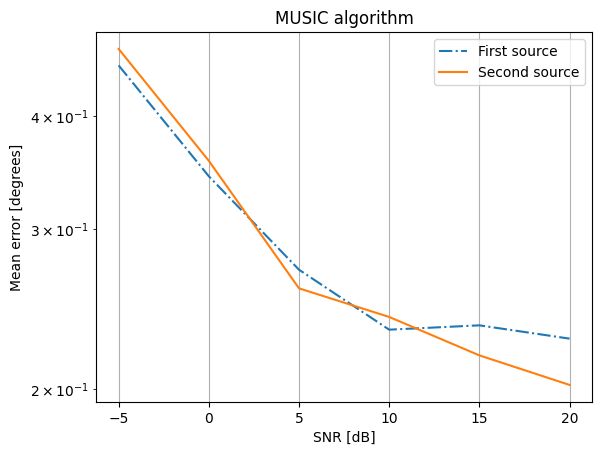

In [69]:
#Ploting the results using semilog
plt.plot(snr_vector,first_angle_error_vector, label=f'First source', linestyle='-.')
plt.plot(snr_vector,second_angle_error_vector, label=f'Second source')
plt.yscale('log')

plt.title('MUSIC algorithm')
plt.grid()
plt.xlabel('SNR [dB]')
plt.ylabel('Mean error [degrees]')
plt.legend()

Bisseção/Falsa posição

|$ i $ | $ a_i $ | $ b_i $ | $ x_i $ | $ f(a_i) $ | $ f(b_i) $ | $ f(x_i) $|
|:---:|---|---|---|---|---|---|
| |  | |  |  |  | 

Secante

$i$ | $x_{i-1}$ | $x_i$ | $f(x_{i-1})$ | $f(x_i)$ | $x_{i+1}$
---|---|---|---|---|---
 | | |  |  |  

Newton

|$i$ | $x_i$ | $x_{i+1}$|
|---|---|---|
 |  |